In [249]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib inline
from cython import *
from sympy import lambdify
import copy
from functools import *

# Parameters

In [314]:
w    = [5,6]   #w[i] is transition frequency of qubit [i] 
wxx  = 0.01     #wxx is coupling energy
f    = [3,0] #f[i] is amplitude of microwave signal applied to qubit [i] 3
w_rf = [w[1], 0]  #w_rf[i] is frequency of --//--
phi  = [0, 0]  #phi[i] is phase of --//--
N    = [2,2]   #2lvls approximation

In [306]:
a = 30
b = 90
st = 3

In [307]:
args = {'a':a, 'b':b,'st':st, 'w_rf':w_rf[0],'phi':phi[0]}

In [333]:
time_coeff = "cos(w_rf*t + phi)*0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
tlist_t = 600
timesteps = 800
tlist = np.linspace(0,tlist_t,timesteps)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


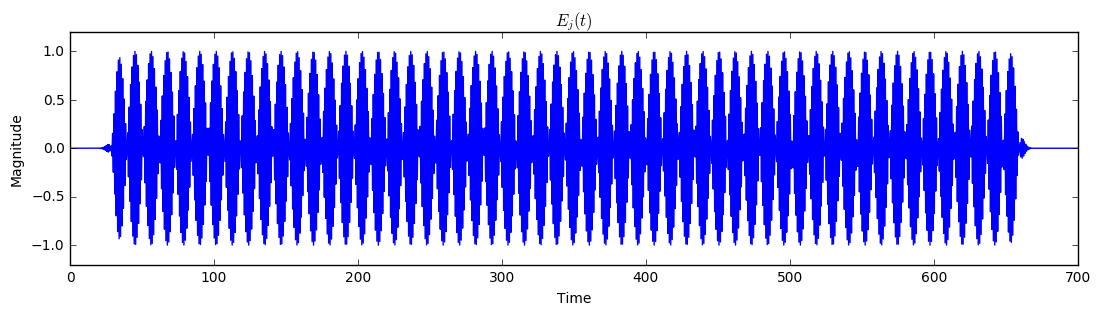

In [294]:
time_c_func = lambdify({'a','b','t','st','w_rf', 'phi'},time_coeff,'numpy')
fig, ax = plt.subplots(1,1, figsize=(13,3))
ax.set_title('$E_j(t)$');
ax.plot(tlist, time_c_func(a=args['a'],b=args['b'],st=args['st'],w_rf=args['w_rf'],phi=args['phi'],t=tlist))
ax.set_ylim(-1.2,1.2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude');

# Operators definition

In [325]:
def T(oper, qubit, N = N):
    if qubit == 1:
        return tensor(oper, identity(N[1]))
    else:
        return tensor(identity(N[0]), oper)
def THq(qubit,w = w):
    return 0.5*w[qubit-1]*T(sigmaz(),qubit)
def THint(wxx = wxx):
    return 0.5*wxx*tensor(sigmax(), sigmax())
def THf(qubit, f=f):
    return f[qubit-1]*T(sigmax(),qubit)
def THsys_t():
    return [THq(1) + THq(2) + THint(),[THf(1), time_coeff]]
def THsys_t_new():
    return [THq(2) + THint(),[THf(1), time_coeff]]

def TSx(qubit, N = N):
    return T(sigmax(),qubit, N)

def TSy(qubit, N = N):
    return T(sigmay(),qubit, N)

def TSz(qubit, N = N):
    return T(sigmaz(),qubit, N)

def TSp(qubit, N = N):
    return T(sigmap(),qubit, N)

def TSm(qubit, N = N):
    return T(sigmam(),qubit, N)

# Visualisation

In [309]:
def Tvis_out(output,every_t = 1):
    graphs = int(len(output.expect)/2)
    fig, axes2d = plt.subplots(graphs,2, figsize=(13,5*graphs), sharex=True)
    #axes[0].set_title('f = %.3f, $t_{gate}$ = %.0f, $\phi$ = %f'%(f,t_gate1,phase1));
    labels = ['$\sigma_x(%d)$','$\sigma_y(%d)$','$\sigma_z(%d)$']
    for idx, axes in enumerate(axes2d):
        for idy, ax in enumerate(axes):
            #print("%d %d"%(idx,idy))
            ax.plot(tlist[::every_t], output.expect[idy*graphs + idx], label=(labels[idx]%(idy) if idx <3 else "%d(%d)"%(idx-3,idy)) + " state")
            #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
            #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
            ax.set_ylim(-1.5,1.1)
            ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
            ax.set_xlabel('Time')

# Dynamics

In [393]:
expected = []
Tpsi0 = tensor(basis(2,1), basis(2,1))

def collapse_list():
    return []
def solve(expected_ops , Tpsi_0 =Tpsi0, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(THsys_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(THsys_t(), Tpsi_0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [422]:
def get_pulse_operator():
    Tpsi = [tensor(basis(2,1), basis(2,1)), tensor(basis(2,1), basis(2,0)), tensor(basis(2,0), basis(2,1)), tensor(basis(2,0), basis(2,0))]
    result = []
    for psi_id, Tpsi0 in enumerate(Tpsi):
        out = solve([],Tpsi0)
        state_final = out.states[-1]
        res_state = []
        print(state_final)
        for Tpsi1 in Tpsi:
            res_state.append((Tpsi1.dag()*state_final).data.toarray()[0][0])
        result.append(res_state)
    print(result)
    return Qobj(result)

In [423]:
op = get_pulse_operator()

10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.32s. Est. time left: 00:00:00:01
30.0%. Run time:   0.49s. Est. time left: 00:00:00:01
40.0%. Run time:   0.66s. Est. time left: 00:00:00:00
50.0%. Run time:   0.84s. Est. time left: 00:00:00:00
60.0%. Run time:   1.00s. Est. time left: 00:00:00:00
70.0%. Run time:   1.14s. Est. time left: 00:00:00:00
80.0%. Run time:   1.25s. Est. time left: 00:00:00:00
90.0%. Run time:   1.35s. Est. time left: 00:00:00:00
Total run time:   1.46s
Quantum object: dims = [[2, 2], [1, 1]], shape = [4, 1], type = ket
Qobj data =
[[-0.04545469+0.02098828j]
 [-0.06186272+0.04644468j]
 [-0.70275463+0.0602444j ]
 [-0.22699362-0.66519899j]]
10.0%. Run time:   0.30s. Est. time left: 00:00:00:02
20.0%. Run time:   0.46s. Est. time left: 00:00:00:01
30.0%. Run time:   0.63s. Est. time left: 00:00:00:01
40.0%. Run time:   0.79s. Est. time left: 00:00:00:01
50.0%. Run time:   0.96s. Est. time left: 00:00:00:00
60.0%. Run time:   1.11s. Est. 

In [427]:
op

Quantum object: dims = [[4], [4]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[-0.22699362-0.66519899j -0.70275463+0.0602444j  -0.06186272+0.04644468j
  -0.04545469+0.02098828j]
 [-0.66430235+0.23817326j -0.06081519-0.70078733j -0.03869041+0.02432458j
  -0.06374473+0.0319764j ]
 [ 0.06374473+0.0319764j   0.03869041+0.02432458j -0.06081519+0.70078733j
  -0.66430235-0.23817326j]
 [ 0.04545469+0.02098828j  0.06186272+0.04644468j -0.70275463-0.0602444j
  -0.22699362+0.66519899j]]

In [397]:
t_gate = 356.01630
args['b'] = args['a'] + t_gate
expected = [TSx(1),TSy(1),TSz(1),TSx(2),TSy(2),TSz(2)]
out = solve([])

10.0%. Run time:   0.17s. Est. time left: 00:00:00:01
20.0%. Run time:   0.33s. Est. time left: 00:00:00:01
30.0%. Run time:   0.54s. Est. time left: 00:00:00:01
40.0%. Run time:   0.71s. Est. time left: 00:00:00:01
50.0%. Run time:   0.87s. Est. time left: 00:00:00:00
60.0%. Run time:   1.02s. Est. time left: 00:00:00:00
70.0%. Run time:   1.14s. Est. time left: 00:00:00:00
80.0%. Run time:   1.25s. Est. time left: 00:00:00:00
90.0%. Run time:   1.36s. Est. time left: 00:00:00:00
Total run time:   1.48s


In [335]:
def observe(output, operators, rotationFreq , every = 1):
    output2 = copy.deepcopy(output)
    output2.expect = []
    for i in range(len(operators)*2):
        output2.expect.append([])
    num_operators = len(operators)
    for time, state in zip(tlist[::every], output.states[::every]):
#         time = tlist_t / timesteps * time_step
        for i, op in enumerate(operators):
            for qubit in [1,2]:
                if rotationFreq[qubit-1] != 0:
                    U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                    TU = T(U,qubit)
                    output2.expect[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
                else:
                    output2.expect[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return output2

def observe_last(output, operators, rotationFreq):
    expectation = []
    time = tlist[-1]
    state = output.states[-1]
    for i, op in enumerate(operators):
        for qubit in [1,2]:
            if rotationFreq[qubit-1] != 0:
                U = (sigmaz()*1j*rotationFreq[qubit-1]/2 * time).expm()
                TU = T(U,qubit)
                expectation[(qubit-1)*num_operators + i].append(expect(TU.dag()*op(qubit)*TU, state))
            else:
                expectation[(qubit-1)*num_operators + i].append(expect(op(qubit), state))
    return expectation

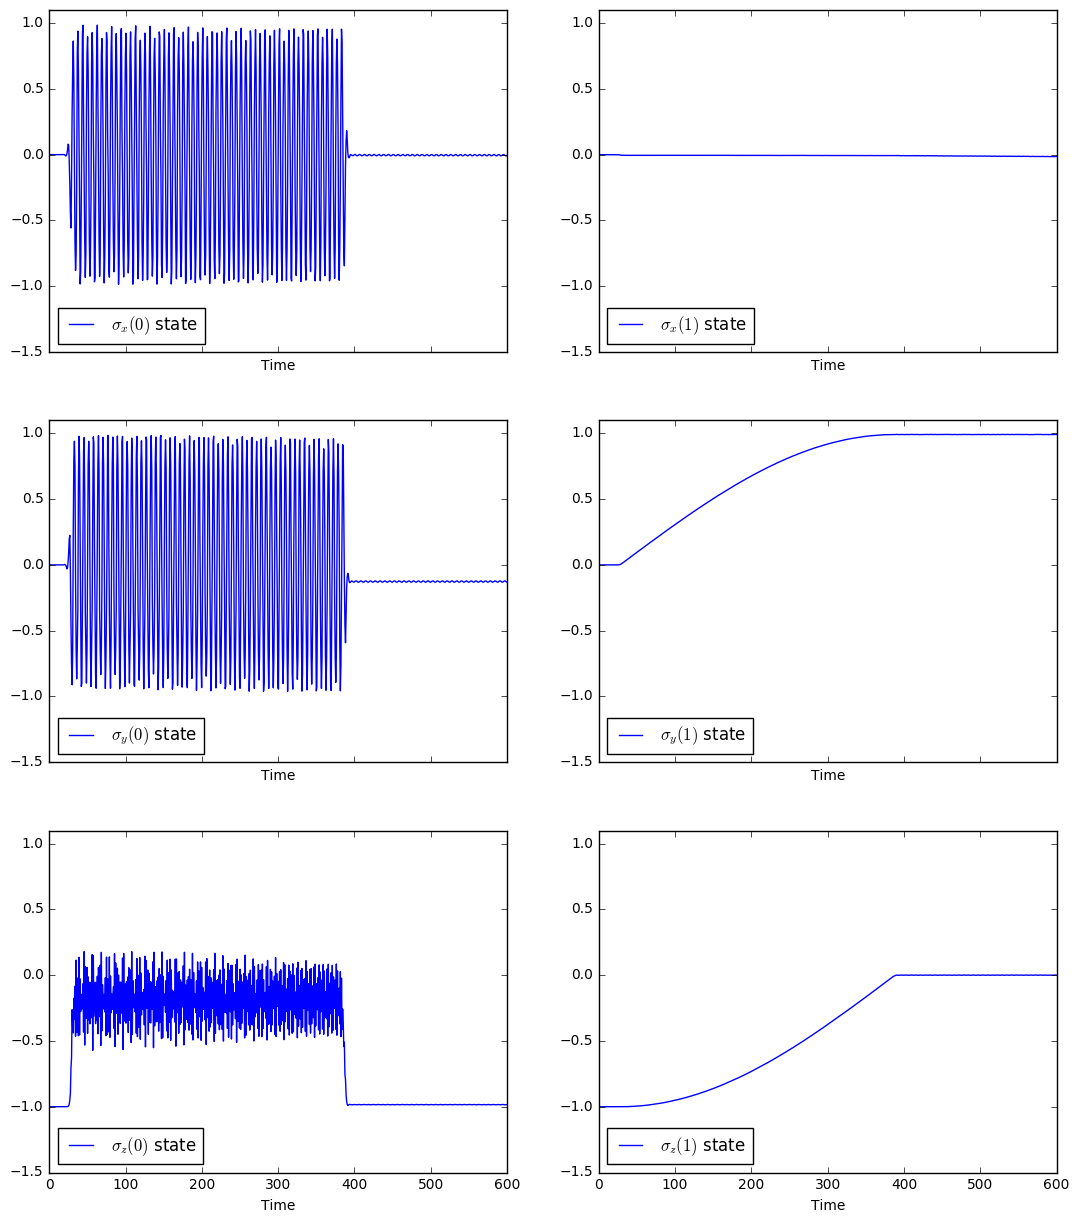

In [399]:
output2 = observe(out, [TSx, TSy, TSz], [w[0],w[1]],1)
Tvis_out(output2,1)

In [368]:
expected = [TSz(2)]
def solve_b(expected, b, b_id):
    args['b'] = b
    print(b_id)
    return solve(expected, False)

sz_final = [ (solve_b(expected, args['a'] + db, b_id).expect[0][-1],db) for b_id, db in enumerate(np.linspace(356.016285, 356.01630,5)) ]

0
1
2
3
4


In [369]:
print(sz_final)

[(1.9705215283322489e-07, 356.01628499999998), (1.9705215283322489e-07, 356.01628875), (1.9705215283322489e-07, 356.01629249999996), (1.9705215283322489e-07, 356.01629624999998), (1.9705215283322489e-07, 356.0163)]


In [404]:
ZX = (-0.5*1j*1/2*np.pi*tensor(sigmaz(),sigmax())).expm()

In [446]:
ZI = (-0.5*1j*1/2*np.pi*tensor(sigmaz(),identity(2))).expm()

In [447]:
IX = (0.5*1j*1/2*np.pi*tensor(identity(2),sigmax())).expm()

In [448]:
CNOT = ZI*op*IX

In [450]:
CNOT*np.exp(-1j*5*np.pi/4)

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[  9.67289281e-01-0.20310796j   1.17909505e-01-0.02655585j
   -7.00025996e-04-0.0585845j    2.89025977e-02-0.06498267j]
 [ -1.25411098e-01+0.02579877j   9.65264170e-01-0.21141676j
    2.78742552e-02-0.04996898j   4.74751713e-03-0.06227441j]
 [ -2.78742551e-02-0.04996898j  -4.74751712e-03-0.06227441j
   -1.25411098e-01-0.02579877j   9.65264170e-01+0.21141676j]
 [  7.00025993e-04-0.0585845j   -2.89025977e-02-0.06498267j
    9.67289281e-01+0.20310796j   1.17909505e-01+0.02655585j]]

In [88]:
expect(TSz(2),ZX * Tpsi0)

-2.220446049250313e-16

In [180]:
new_t_list = np.linspace(0,2,100)
evolution = [(T(sigmaz(),1)*1j*2*np.pi/2 * t).expm()*Tpsi0 for t in new_t_list]

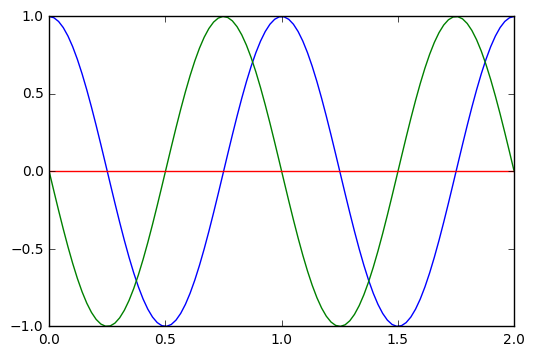

In [181]:
plt.plot(new_t_list, expect(TSx(1),evolution))
plt.plot(new_t_list, expect(TSy(1),evolution))
plt.plot(new_t_list, expect(TSz(1),evolution))


In [428]:
op.dims = [[2,2],[2,2]]

In [429]:
op

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[-0.22699362-0.66519899j -0.70275463+0.0602444j  -0.06186272+0.04644468j
  -0.04545469+0.02098828j]
 [-0.66430235+0.23817326j -0.06081519-0.70078733j -0.03869041+0.02432458j
  -0.06374473+0.0319764j ]
 [ 0.06374473+0.0319764j   0.03869041+0.02432458j -0.06081519+0.70078733j
  -0.66430235-0.23817326j]
 [ 0.04545469+0.02098828j  0.06186272+0.04644468j -0.70275463-0.0602444j
  -0.22699362+0.66519899j]]